In [2]:
%load_ext autoreload
%autoreload 2

from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
import os
import sys

# Set the root directory to BPX Challenge Home path
os.chdir("../")

from scripts.env import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Plot some of the good predictions

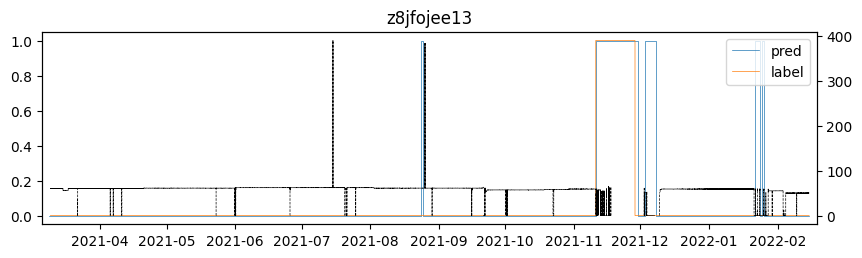

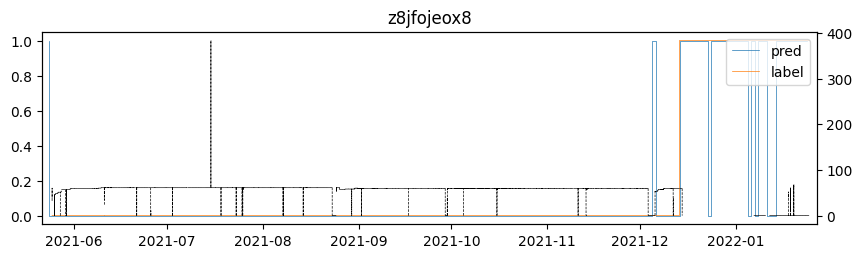

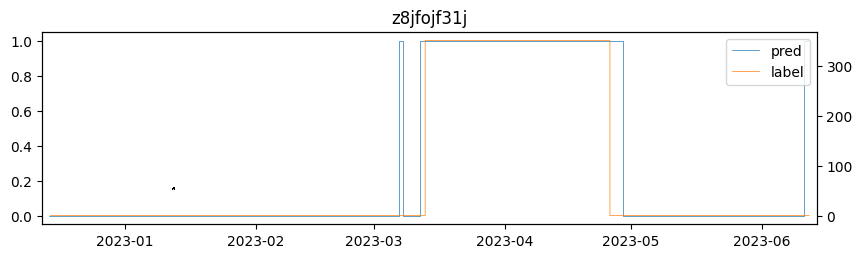

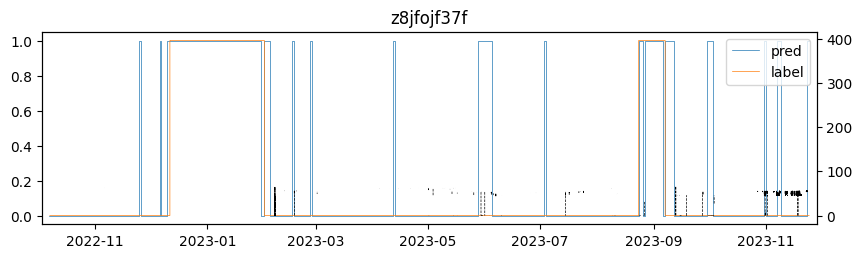

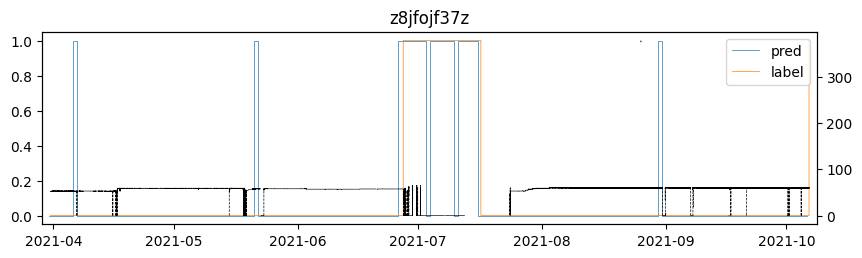

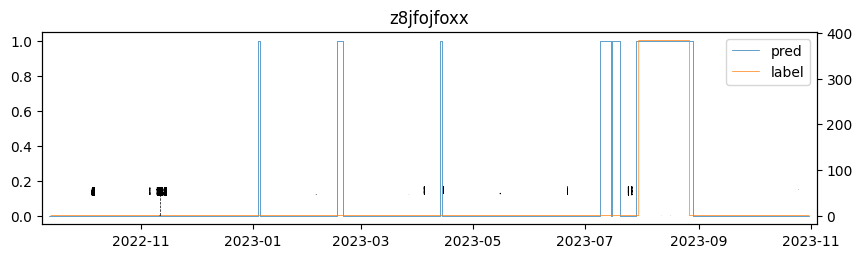

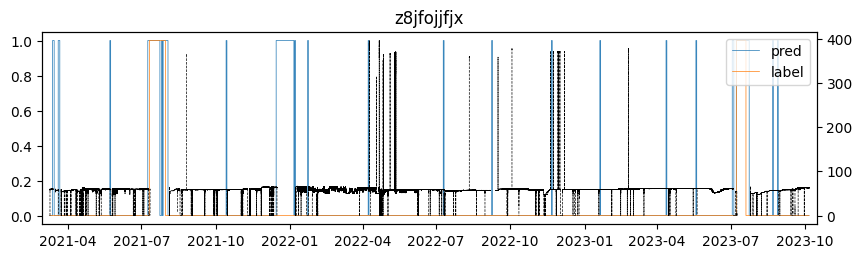

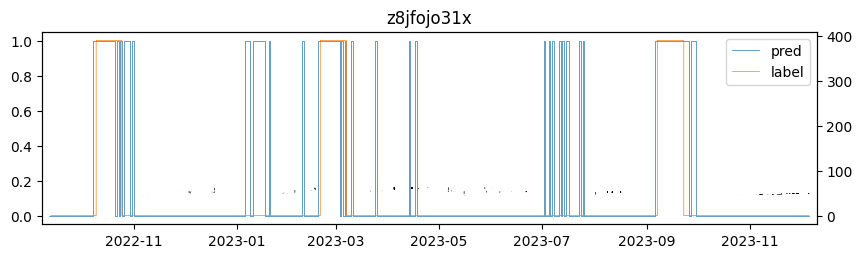

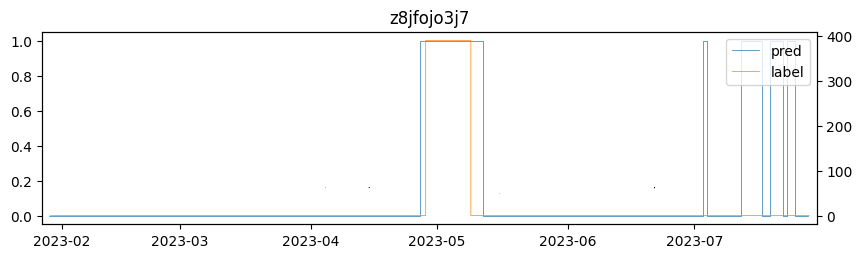

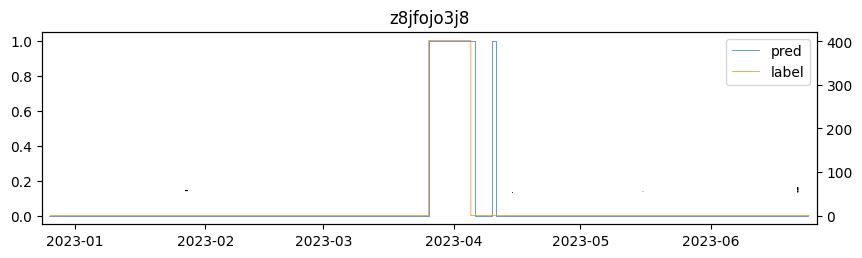

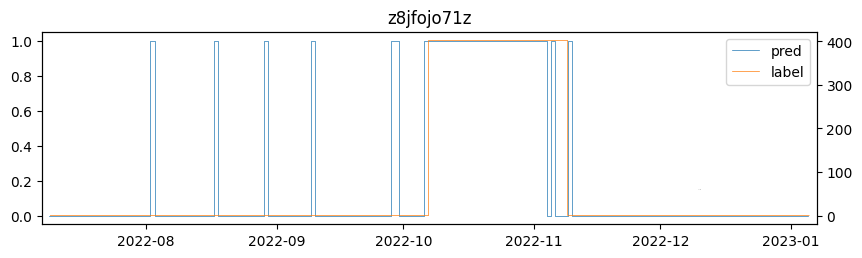

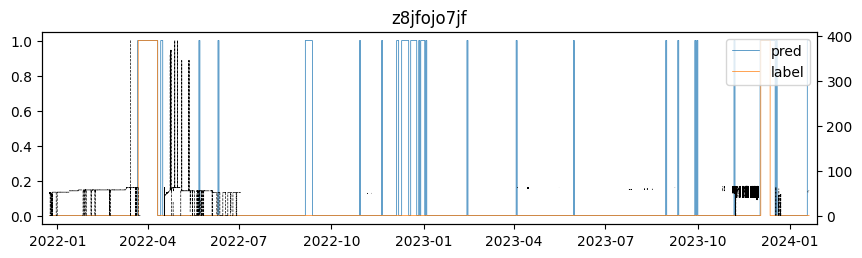

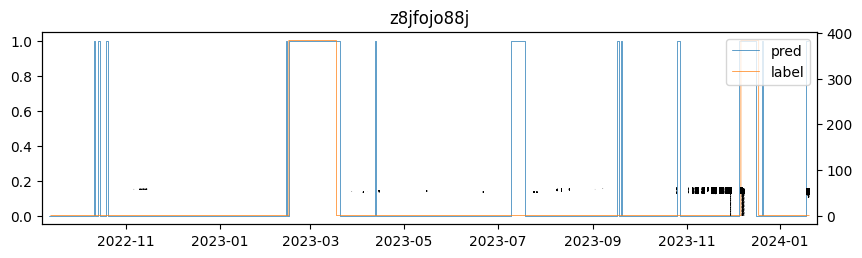

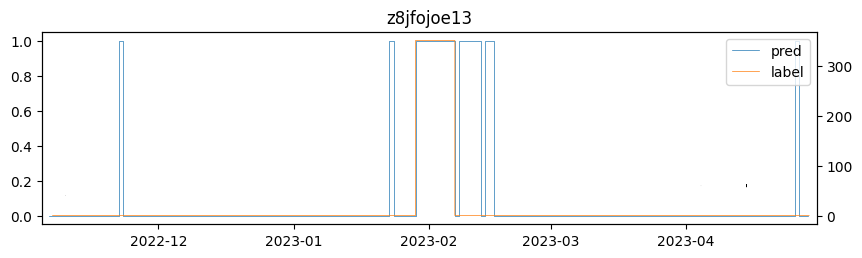

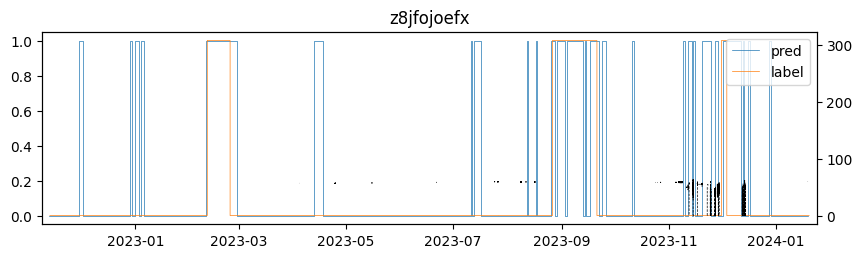

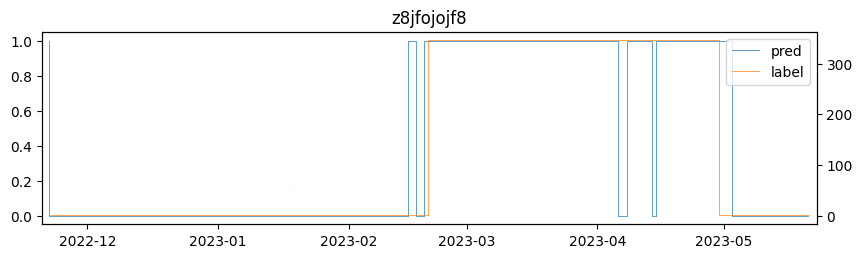

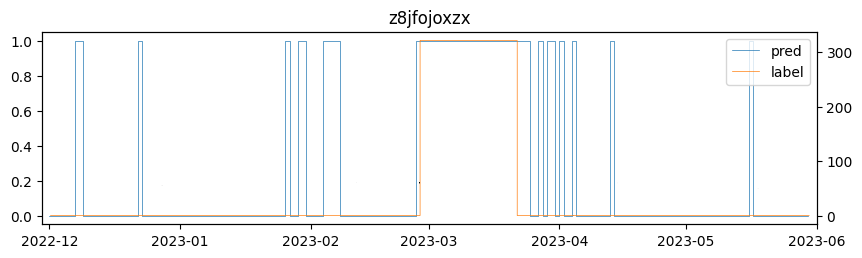

In [5]:
pred_folders = sorted(glob(f"{PRED_FOL}_{SLIDE_N}/*.csv"))
file = np.random.choice(pred_folders)
good_wells = ['z8jfojee13', 'z8jfojeox8', 'z8jfojf31j', 'z8jfojf37f', 'z8jfojf37z',
                'z8jfojfoxx', 'z8jfojjfjx', 'z8jfojo31x', 'z8jfojo3j7', 'z8jfojo3j8', 
                'z8jfojo71z', 'z8jfojo7jf', 'z8jfojo88j', 'z8jfojoe13', 'z8jfojoefx', 
                'z8jfojojf8', 'z8jfojoxzx']


for _a in good_wells:
    file = f"{PRED_FOL}_{SLIDE_N}/pred_{_a}.csv"
    API = file.split("/")[-1].replace(".csv","").split("_")[1]
    label_folder = sorted(glob(f"{ESP_OUTPUT_FOLDER}_{SLIDE_N}/{API}/*.parquet"))
    label_df = pd.concat([pd.read_parquet(file) for file in label_folder])
    label_df.sort_index()


    df = pd.read_csv(file)
    df["Date"] = pd.to_datetime(df["Date"])
    fig,ax = plt.subplots(figsize=(10,2.5))
    ax.step(df.Date, df.Fail, lw=0.5, label="pred")
    ax.step(label_df.index, label_df.Label, lw=0.5, label="label")
    ax.legend(loc="upper right")
    ax.set_title(df.API[0])
    ax.margins(x=0.01)
    bx = ax.twinx()
    bx.plot(label_df.index, label_df.motor_frequency, c="k", lw=0.5, ls="--")
    # bx.plot(label_df.index, label_df.output_amps_phase_b, c="k", lw=0.5, ls="--")
    # bx.set_ylim(0,10)
    plt.show()

### Plot the confusion matrix

In [6]:

os.system("python scripts/evaluate.py")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/josesmac/Documents/Competitions/BPX_Challenge/JTK-Challenge/jtk/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9297872185707092
       test_fbeta           0.9473494291305542
        test_loss           0.23977762460708618
──────────────────────────────��─────────────────────────────────────────────────────────────────────────────────────────
──────────────────
Confusion Matrix
──────────────────
[[220  15]
 [ 20 215]]
──────────────────


0

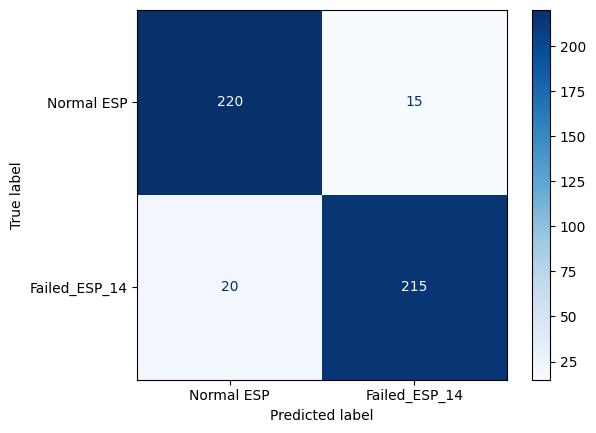

In [11]:
cm = np.array([[220,  15],[20, 215]])
cls_labels = np.array(["Normal ESP",f"Failed_ESP_{SLIDE_N}"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_labels)
disp.plot(cmap="Blues")
plt.show()